## Image Captioning (VGG16 + LSTM)
### Python · Flickr 8k Dataset, Image Caption Test V2.0


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-05-30 00:28:58.172270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 00:28:59.235582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#!pip install seaborn

In [3]:
BASE_DIR = '/home/chohi/work/imageclass'
WORKING_DIR = '/home/chohi/work/imageclass/work'

### Extracting Image Features

In [4]:
model = VGG16()
# This sets the output layer for the new model. It's extracting the output from the second-to-last layer of the existing model.
# i.e We are leaving the "Prediction (Dense)" layer of the VGG16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

2024-05-30 00:29:05.145650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2023] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30992 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-05-30 00:29:05.146259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2023] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31133 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2024-05-30 00:29:05.146799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2023] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31133 MB memory:  -> device: 2, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0
2024-05-30 00:29:05.147354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2023] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31133 MB memory:  -> device: 3, name: Tesla V100-DGXS-32GB, pci bus id

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Define a dictionary to store image features
features = {}

# Specify the directory containing the images
directory = os.path.join(BASE_DIR, 'Images')

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG
    image = preprocess_input(image)

    # Extract features using the pre-trained model
    feature = model.predict(image, verbose=0)

    # Get image ID from the filename
    image_id = img_name.split('.')[0]

    # Store extracted features in the dictionary
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1716996548.072811 3561757 service.cc:146] XLA service 0x7f6384003210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716996548.072846 3561757 service.cc:154]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
I0000 00:00:1716996548.072855 3561757 service.cc:154]   StreamExecutor device (1): Tesla V100-DGXS-32GB, Compute Capability 7.0
I0000 00:00:1716996548.072860 3561757 service.cc:154]   StreamExecutor device (2): Tesla V100-DGXS-32GB, Compute Capability 7.0
I0000 00:00:1716996548.072864 3561757 service.cc:154]   StreamExecutor device (3): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-05-30 00:29:08.096457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-30 00:29:08.237642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:17169

KeyboardInterrupt: 

In [7]:
# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))



In [6]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
     features = pickle.load(f)

### Loading Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# Create an empty dictionary to store the mapping of image IDs to captions
mapping = {}

# Iterate through each line in the 'captions_doc'
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    
    # Check if the line has enough elements (at least 2)
    if len(line) < 2:
        continue
    # Extract the image ID and caption from the tokens    
    image_id, caption = tokens[0], tokens[1:]
    
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # Convert the caption list to a string by joining its elements
    caption = " ".join(caption)
    
    # Create a list if the image ID is not already in the mapping dictionary
    if image_id not in mapping:
        mapping[image_id] = []
    
    # Store the caption in the list associated with the image ID
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

### Text Preprocessing

In [10]:
def clean(mapping):
    
    # Iterate through each key-value pair in the 'mapping' dictionary
    for key, captions in mapping.items():
        
        # Iterate through each caption associated with the current key
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
        
            # Preprocessing steps for the caption:

            # Convert the caption to lowercase
            caption = caption.lower()
            
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
print(len(all_captions))
print()
print(all_captions[:10])

40455

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [15]:
# Create a tokenizer object to handle text tokenization
tokenizer = Tokenizer()

# Fit the tokenizer on the provided text data (all_captions)
# This process:
#   - Analyzes the text to identify unique words (vocabulary)
#   - Assigns a unique integer ID to each word
tokenizer.fit_on_texts(all_captions)

# Calculate the vocabulary size (number of unique words) plus 1
# The extra 1 accounts for the 0-th index, which is often reserved for padding
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train Test Split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    # Initialize empty lists to store data
    X1, X2, y = list(), list(), list()
    
    n = 0 # Counter for tracking batch size
    
    while 1: # Infinite Loop to yield batches
        
        for key in data_keys: # Iterate through each image key
            n += 1
            
            captions = mapping[key]  # Retrieve captions associated with the image
            
            # process each caption
            for caption in captions:
               
            # Tokenize the caption into a sequence of integer IDs
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Split the sequence into multiple X, y pairs for training
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-Hot Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            # If a batch is complete, yield it and reset        
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) # Convert to NumPy arrays
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()  # Reset lists for the next batch
                n = 0  # Reset counter

### Modelling

In [29]:
# Encoder Layers:-

# Image feature layers:
inputs1 = Input(shape=(4096,)) # Input for image features (4096 dimensions)
fe1 = Dropout(0.2)(inputs1) # Apply dropout for regularization
fe2 = Dense(256, activation='elu')(fe1) # Dense layer with ReLU activation

# Sequence feature layers:
inputs2 = Input(shape=(max_length,)) # Input for text sequences
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) # Word embedding layer
se2 = Dropout(0.2)(se1)
se3 = LSTM(256, use_cudnn=False)(se2) # LSTM layer to model sequential information

# Decoder layers:-
decoder1 = add([fe2, se3]) # Combine image and sequence features
decoder2 = Dense(256, activation='elu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # Output layer with softmax for word probabilities

model = Model(inputs=[inputs1, inputs2], outputs=outputs) # Define model with two inputs and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')



# Plot the model
#plot_model(model, show_shapes=True)

In [30]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - loss: 5.7308
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 3.9257
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 3.4396
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 3.1634
227/227 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - loss: 2.9747
227/227 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - loss: 2.8409
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - loss: 2.7338
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - loss: 2.6401
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - loss: 2.5620
227/227 ━━━━━━━━━━━━━━━━━━━━ 47s 205ms/step - loss: 2.4996
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 205ms/step - loss: 2.4423
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - loss: 2.3842
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.3286
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - loss: 2.2778
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.2334
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.1931
227/227 ━━━━━━━━━━━━━━━━━━━━ 47s 206ms/step - loss: 2.1479

In [31]:
# save the model
model.save(WORKING_DIR+'/img_caption_model.h5')

### Generate Captions for Image

In [32]:
def idx_to_word(integer, tokenizer):
    """
    Converts a numerical token ID back to its corresponding word using a tokenizer.

    Args:
        integer: The integer ID representing the word.
        tokenizer: The tokenizer object that was used to tokenize the text.

    Returns:
        The word corresponding to the integer ID, or None if the ID is not found.
    """

    # Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        # If the integer ID matches the index of a word, return the word
        if index == integer:
            return word

    # If no matching word is found, return None
    return None

In [38]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        model: The trained image captioning model.
        image: The image to generate a caption for.
        tokenizer: The tokenizer used to convert text to numerical sequences.
        max_length: The maximum length of the generated caption.

    Returns:
        The generated caption as a string.
    """
        
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        
       # Tokenize the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
       
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
       
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [40]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.2 MB/s eta 0:00:0000:0100:01


In [41]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.495648
BLEU-2: 0.275937


### Testing Model

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles underwater endseq
startseq red-headed boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq
--------------------Predicted--------------------
startseq boy smiles underwater endseq


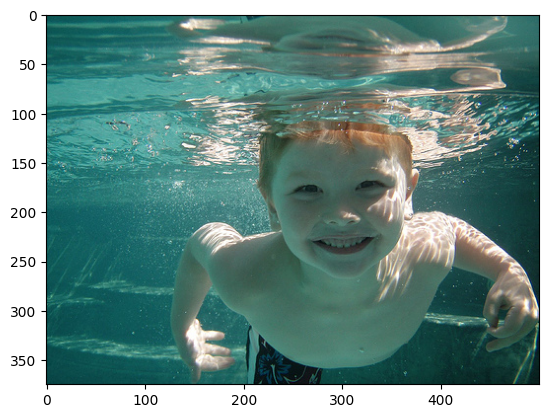

In [43]:
generate_caption("1096165011_cc5eb16aa6.jpg")

---------------------Actual---------------------
startseq people on atvs and dirt bikes are traveling along worn path in field surrounded by trees endseq
startseq three people are riding around on atv 's and motorcycles endseq
startseq three people on motorbikes follow trail through dry grass endseq
startseq three people on two dirt-bikes and one four-wheeler are riding through brown grass endseq
startseq three people ride off-road bikes through field surrounded by trees endseq
--------------------Predicted--------------------
startseq three people are playing cricket on grassy field endseq


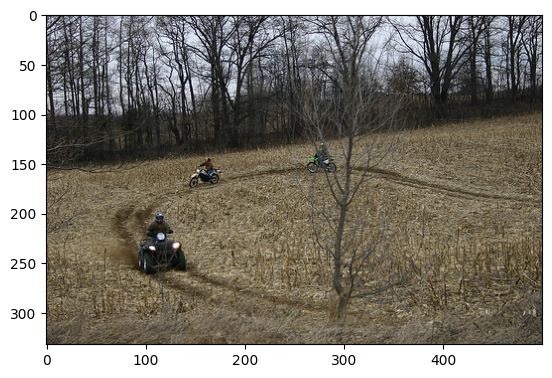

In [44]:
generate_caption("112243673_fd68255217.jpg")

---------------------Actual---------------------
startseq two children are laughing in the grass endseq
startseq two girls laughing outside in yard endseq
startseq two girls standing on grass face each other endseq
startseq two young girls are playing and laughing in green grassy yard endseq
startseq two young girls playing together endseq
--------------------Predicted--------------------
startseq two girls are playing with red and red ball endseq


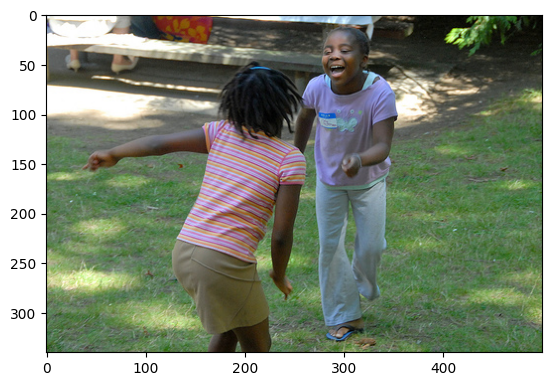

In [45]:
generate_caption("1220401002_3f44b1f3f7.jpg")

---------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
--------------------Predicted--------------------
startseq two construction workers take seat on steel beam endseq


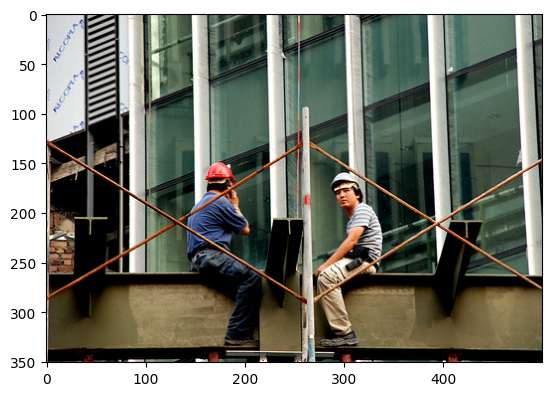

In [46]:
generate_caption("1055753357_4fa3d8d693.jpg")

### Testing with New Images

In [ ]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def new_caption(image_path, model, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        image_path (str): Path to the image file.
        model: The trained image captioning model.
        tokenizer: The tokenizer used to encode text for the model.
        max_length: The maximum length of the generated caption.

    Returns:
        str: The generated caption.
    """

    # Load VGG16 model and restructure it to output features from the second-to-last layer
    vgg_model = VGG16()
    vgg_model = keras.models.Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Display the image
    img = load_img(image_path)
    plt.imshow(img)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image using VGG16
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption using the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)

    return caption

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/sitting_bench.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/children_playing.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/cafe.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/dog-playtime-927x388.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/dirt bike.jpg",model,tokenizer,max_length)

In [ ]:
new_caption("/home/chohi/work/imageclass/input/image-caption-test-v2-0/kid_smiling.jpg",model,tokenizer,max_length)